# Setup

In [62]:
# Import necessary modules
from preprocessing import read_img, segment_image, sharpen_image, create_mask_for_plant
from augmentation import augment_data
from model import build_model
from predict import predict
from validate import print_classification_report, plot_confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
from keras.applications import xception
from sklearn.model_selection import train_test_split


from tqdm import tqdm
import shutil

In [33]:
data_folder = 'input/fire_dataset'
train_data_folder = 'input/fire_dataset/fire_images'
test_date_folder  = 'input/fire_dataset/non_fire_images'

In [34]:
# Copy pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Copy Xception models
source_dir = 'input/keras-pretrained-models'
for filename in os.listdir(source_dir):
    if 'xception' in filename:
        shutil.copy(os.path.join(source_dir, filename), models_dir)

# Show
print(os.listdir(models_dir))

['mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5', 'efficientnetb4_notop.h5', 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5', 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5', 'xception_weights_tf_dim_ordering_tf_kernels.h5']


In [35]:
# Define the categories of images, specifically for fire and non-fire images
categories = ['fire_images', 'non_fire_images']

# Calculate the number of categories
len_categories = len(categories)

# Initialize a dictionary to keep count of images in each category
image_count = {}

# Initialize a list to store data about each image
train_data = []

# Loop through each category with its index using tqdm for a progress bar
for i, category in tqdm(enumerate(categories)):
    # Construct the folder path for the current category
    class_folder = os.path.join(data_folder, category)
    label = category  # Assign the category name as label

    # Initialize the count list for the current category in the image_count dictionary
    image_count[category] = []
    
    # Loop through each image file in the category's folder
    for path in os.listdir(os.path.join(class_folder)):
        # Append the category to the image count list for this category
        image_count[category].append(category)
        
        # Append a list containing the relative path of the image, its category index, and label to the train_data list
        train_data.append(['{}/{}'.format(category, path), i, category])

# Show Image Count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

# Create DF
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
# display head
df.head()

2it [00:00, 466.55it/s]

fire_images -> 755
non_fire_images -> 244


,file,id,label
0,fire_images/fire.753.png,0,fire_images
1,fire_images/fire.12.png,0,fire_images
2,fire_images/fire.747.png,0,fire_images
3,fire_images/fire.592.png,0,fire_images
4,fire_images/fire.586.png,0,fire_images


# EDA

### Sample Images

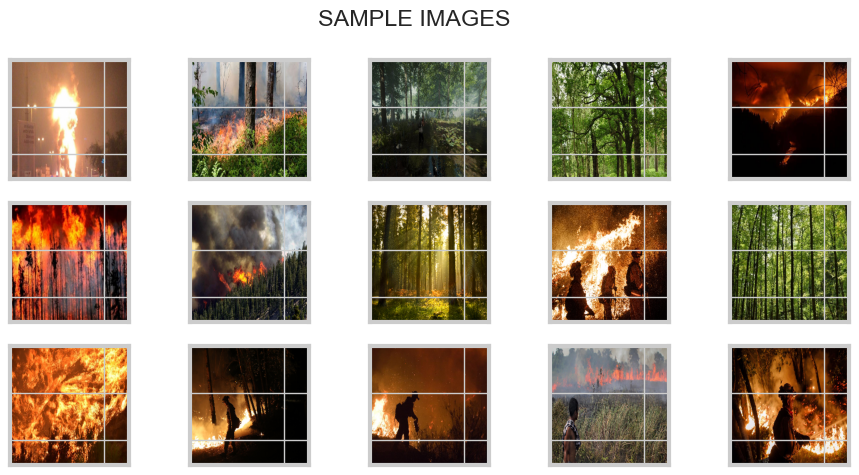

In [37]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.)
plt.show();

### Sample processed images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


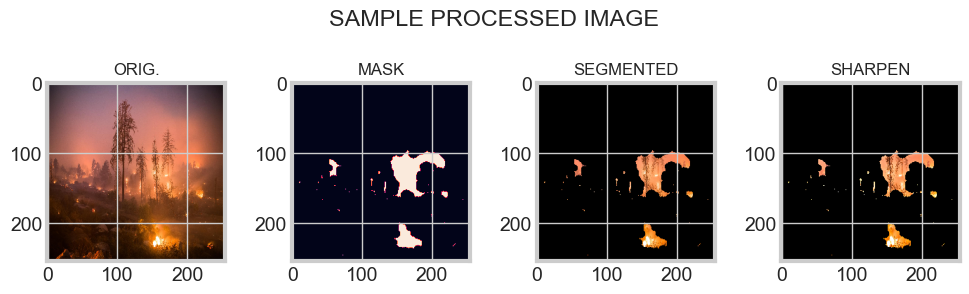

In [39]:
img = read_img(df['file'][102],(255,255))

image_mask = create_mask_for_plant(img)

image_segmented = segment_image(img)

image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGES', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255)
ax[1].imshow(image_mask)
ax[2].imshow(image_segmented)
ax[3].imshow(image_sharpen)

### Print some EDA values

In [42]:
INPUT_SIZE=255

X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #read image
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    #masking and segmentation
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    # augment data
    img_augmented = augment_data(image_sharpen)
    x = xception.preprocess_input(np.expand_dims(img_augmented.copy(), axis=0))
    X_train[i] = x

999it [00:32, 30.83it/s]


In [43]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (999, 255, 255, 3)
Train Image Size:  194879925


# Preprocessing and Augmentation

In [44]:
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [45]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

FIRE IMAGES ON TRAINING DATA:  610
NON-FIRE IMAGES ON TRAINING DATA:  189


In [46]:
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 958ms/step


In [47]:
# Print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (799, 2048)
Train Size:  1636352
Validation Shape:  (200, 2048)
Validation Size:  409600


# Build Model

In [53]:
history = build_model.fit(bf_train_x, y_train, validation_data=(bf_train_val, y_val), epochs=100, batch_size=32);

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7615 - loss: 0.5708 - val_accuracy: 0.7250 - val_loss: 0.5462
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7774 - loss: 0.4767 - val_accuracy: 0.8100 - val_loss: 0.4370
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8119 - loss: 0.3865 - val_accuracy: 0.8550 - val_loss: 0.3593
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8769 - loss: 0.3285 - val_accuracy: 0.8800 - val_loss: 0.3277
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8789 - loss: 0.3029 - val_accuracy: 0.8800 - val_loss: 0.3247
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8820 - loss: 0.2896 - val_accuracy: 0.8850 - val_loss: 0.3071
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8755 - loss: 0.2789 - val_accuracy: 0.8900 - val_loss: 0.2970
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8713 - loss: 0.2855 - val_accuracy: 0.8700 - v

# Metrics

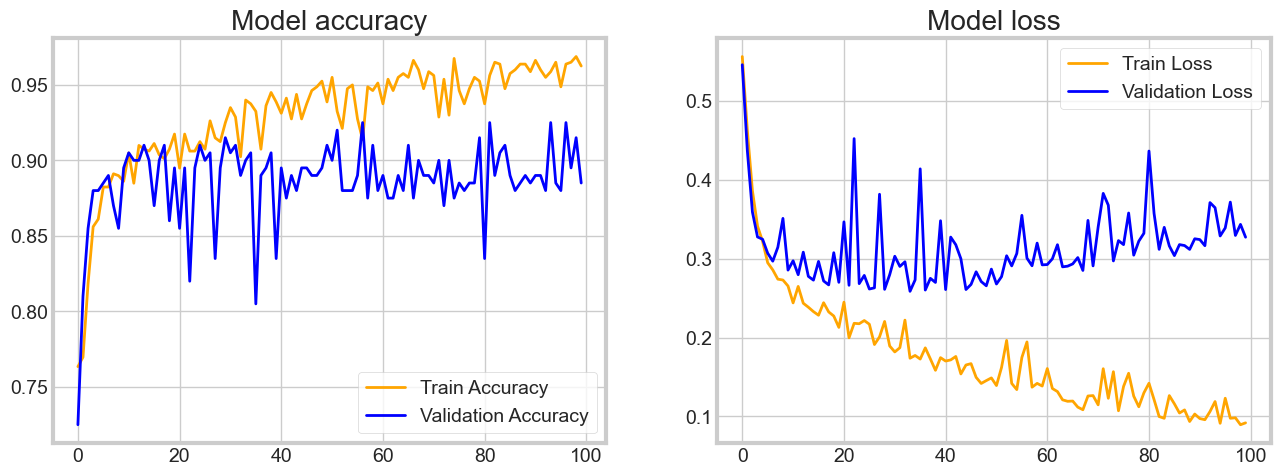

In [56]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('Model accuracy')
ax[1].set_title('Model loss')

# Plot training loss and accuracy
ax[1].plot(history.history['loss'], color='orange', label='Train Loss', lw=2)
ax[0].plot(history.history['accuracy'], color='orange', label='Train Accuracy', lw=2)

# Plot validation loss and accuracy
ax[1].plot(history.history['val_loss'], color='blue', label='Validation Loss', lw=2)
ax[0].plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy', lw=2)

ax[0].legend()
ax[1].legend()

# Prediction and Validation

/Users/devynmiller/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,057 (2.06 MB)

 Trainable params: 541,057 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       145
           1       0.33      0.02      0.03        55

    accuracy                           0.72       200
   macro avg       0.53      0.50      0.44       200
weighted avg       0.62      0.72      0.62       200



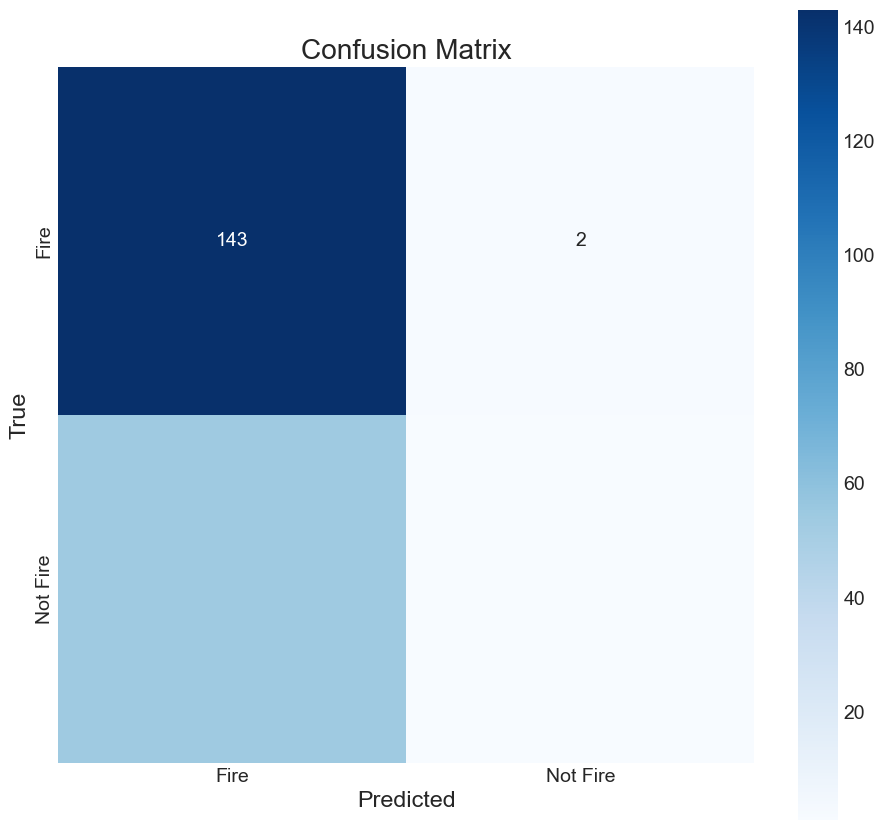

In [61]:
# Predict using the model
predictions = predict(build_model, bf_train_val)

# Validate predictions
print_classification_report(y_val, predictions.round())
plot_confusion_matrix(y_val, predictions.round())
